# 2D toy model

## Libraries used

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numba as numba
from numba import njit
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from matplotlib.image import NonUniformImage
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar
from numba import njit

The libraries used are numpy to do the linear algebra calculations, matplotlib to do the plots. 

Here I group all the functions that I am going to use later, so if I want to run a specific part of the code I need to run only the following cell.                     

In [2]:
# Parameters of the potential
x0=1.0
a0=1.0/3.0
b0=5.0/3.0
u0=5.0
w0=1.0/5.0

@njit
def potential(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    U = u0*(np.exp(-(q[0]**2 + q[1]**2)) - 3.0/5.0*np.exp(-(q[0]**2 + (q[1] - b0)**2)) - np.exp(-((q[0]-x0)**2+q[1]**2)) - np.exp(-((q[0]+x0)**2 + q[1]**2))) + w0*(q[0]**4 + (q[1] - a0)**4)
    return U

@njit
def force(q, x0 = 1.0, a0 = 1.0/3.0, b0 = 5.0/3.0, u0 = 5.0, w0 = 1.0/5.0):
    x2 = q[0]**2  # Square of x coordinate
    y2 = q[1]**2  # Square of y coordinate
    # Exponentials to speed up code
    e1 = np.exp(-(x2 + y2))
    e2 = np.exp(-(x2+(q[1]- b0)**2))
    e3 = np.exp(-((q[0] - x0)**2 + y2))
    e4 = np.exp(-((q[0] + x0)**2 + y2))
    # Components of the force
    fx = 2*u0*(q[0]*e1 -3.0/5.0*q[0]*e2 - (q[0]-x0)*e3 - (q[0]+x0)*e4)-4.0*w0*q[0]**3
    fy = 2*u0*(q[1]*e1 -3.0/5.0*(q[1] - b0)*e2 - q[1]*e3 - q[1]*e4)-4.0*w0*(q[1] - a0)**3
    return np.array([fx, fy])

@njit
def state(q): #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    state = 0  # Transition state
    tmp = q[0]**2 + 1 + q[1]**2
    if tmp - 2*q[0] < 1.0:
        U = potential(q)
        if U <-2.4:  # Product state
            state = 1
    if tmp + 2*q[0] < 1.0:
        U = potential(q)
        if U <-2.4:  # Reactant state
            state = -1
    return state

@njit
def z_dist(q):
    return np.sqrt((q[0] - 1)**2 + q[1]**2) # Distance from the center of the product state

## Toy model potential

I define the toy model potential through the following parameters (moved to the top).

The potential is a 2D potential that has three minima centered at $\mathbf{x_R} = (x_R,
yR) = (-1, 0)$, $\mathbf{x_I} = (x_I , y_I ) = (0, 1.5)$, and $\mathbf{x_P} = (x_P, y_P) = (1,
0)$, respectively.

I plot the potential and the force that a particle feels in order to understand the problem better.

In [3]:
## Line to make plot in other windows of browser
#%matplotlib

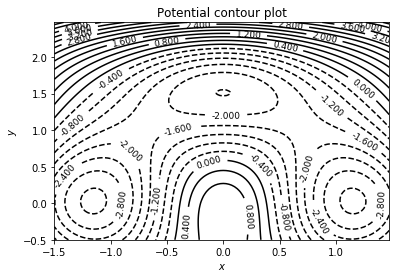

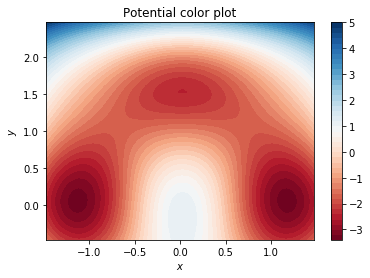

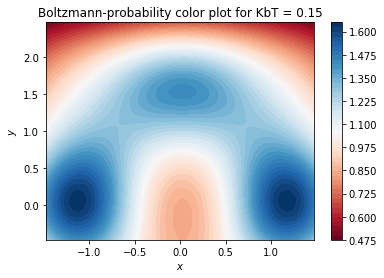

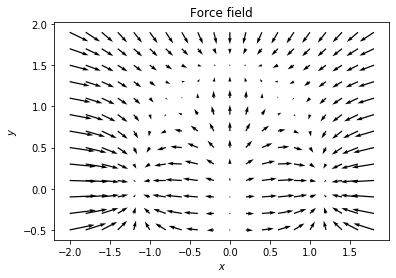

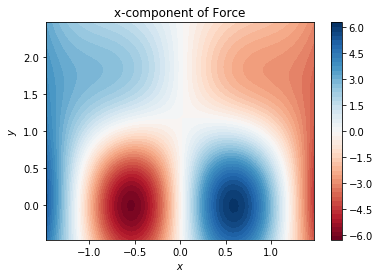

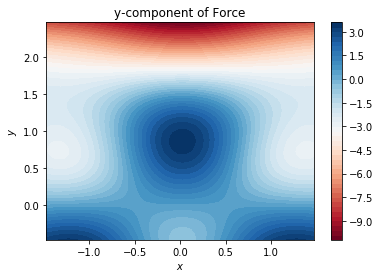

In [4]:
# Resolution of the contour plot
delta = 0.025
x = np.arange(-1.5, 1.5, delta)
y = np.arange(-0.5, 2.5, delta)
X, Y = np.meshgrid(x, y)
I = X*0+1
U1 = u0*(np.exp(-(X**2 + Y**2)) - 3.0/5.0*np.exp(-(X**2 + (Y - b0*I)**2)) - np.exp(-((X-x0*I)**2+Y**2)) - np.exp(-((X+x0*I)**2 + Y**2)))
U2 = w0*(X**4 + (Y - a0*I)**4)
U = U1 + U2

fig, ax = plt.subplots()
CS = ax.contour(X, Y, U, 20, colors='k')
ax.clabel(CS, fontsize=9, inline=1)
ax.set_title('Potential contour plot')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')

# make these smaller to increase the resolution
dx, dy = 0.05, 0.05

# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]
I = x*0+1

U1 = u0*(np.exp(-(x**2 + y**2)) - 3.0/5.0*np.exp(-(x**2 + (y - b0*I)**2)) - np.exp(-((x-x0*I)**2+y**2)) - np.exp(-((x+x0*I)**2 + y**2)))
U2 = w0*(x**4 + (y - a0*I)**4)
U = U1+ U2
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
U = U[:-1, :-1]
levels = MaxNLocator(nbins=50).tick_values(U.min(), U.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., U, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Potential color plot')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]
I = x*0+1

U1 = u0*(np.exp(-(x**2 + y**2)) - 3.0/5.0*np.exp(-(x**2 + (y - b0*I)**2)) - np.exp(-((x-x0*I)**2+y**2)) - np.exp(-((x+x0*I)**2 + y**2)))
U2 = w0*(x**4 + (y - a0*I)**4)
U = np.exp(-0.15*(U1+ U2))
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
U = U[:-1, :-1]
levels = MaxNLocator(nbins=50).tick_values(U.min(), U.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmap = plt.get_cmap('RdBu')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig, ax = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = ax.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., U, levels=levels,
                  cmap=cmap)
fig.colorbar(cf, ax=ax)
ax.set_title('Boltzmann-probability color plot for KbT = 0.15')
ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$y$')
plt.show()


## Vector field of the force field
x,y = np.meshgrid(np.arange(-2.0,2.0,0.2),np.arange(-0.5,2.0,0.2))

I = x*0+1
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-((x - x0*I)**2 + y**2))
e4 = np.exp(-((x + x0*I)**2 + y**2))
fx = 2*u0*(x*e1 -3.0/5.0*x*e2 - (x-x0)*e3 - (x+x0)*e4)-4.0*w0*x**3
fy = 2*u0*(y*e1 -3.0/5.0*(y - b0)*e2 - y*e3 - y*e4)-4.0*w0*(y - a0)**3

# Plot of force field
plt.figure()
plt.quiver(x,y,fx,fy, units='width')
plt.title("Force field")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.show()

## Colour plot of the x-component of the force
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]
I = x*0+1
e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-((x - x0*I)**2 + y**2))
e4 = np.exp(-((x + x0*I)**2 + y**2))
Fx = 2*u0*(x*e1 -3.0/5.0*x*e2 - (x-x0*I)*e3 - (x+x0*I)*e4)-4.0*w0*x**3
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
Fx = Fx[:-1, :-1]
levelsX = MaxNLocator(nbins=50).tick_values(Fx.min(), Fx.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmapX = plt.get_cmap('RdBu')
norm = BoundaryNorm(levelsX, ncolors=cmapX.N, clip=True)

fig, axX = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cf = axX.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., Fx, levels=levelsX,
                  cmap=cmapX)
fig.colorbar(cf, ax=axX)
axX.set_title('x-component of Force')
axX.set_xlabel(r'$x$')
axX.set_ylabel(r'$y$')
plt.show()

## Colour plot of the y-component of the force
# generate 2 2d grids for the x & y bounds
y, x = np.mgrid[slice(-0.5, 2.5 + dy, dy),
                slice(-1.5, 1.5 + dx, dx)]
I = x*0+1

e1 = np.exp(-(x**2 + y**2))
e2 = np.exp(-(x**2+(y- b0*I)**2))
e3 = np.exp(-((x - x0*I)**2 + y**2))
e4 = np.exp(-((x + x0*I)**2 + y**2))
Fy = 2.0*u0*(y*e1 -3.0/5.0*(y - b0*I)*e2 - y*e3 - y*e4)-4.0*w0*(y - a0*I)**3
# x and y are bounds, so z should be the value *inside* those bounds.
# Therefore, remove the last value from the z array.
Fy = Fy[:-1, :-1]
levelsY = MaxNLocator(nbins=50).tick_values(Fy.min(), Fy.max())


# pick the desired colormap, sensible levels, and define a normalization
# instance which takes data values and translates those into levels.
cmapY = plt.get_cmap('RdBu')
normY = BoundaryNorm(levelsY, ncolors=cmapY.N, clip=True)

fig, axY = plt.subplots()

# contours are *point* based plots, so convert our bound into point
# centers
cfY = axY.contourf(x[:-1, :-1] + dx/2.,
                  y[:-1, :-1] + dy/2., Fy, levels=levelsY,
                  cmap=cmapY)
fig.colorbar(cfY, ax=axY)
axY.set_title('y-component of Force')
axY.set_xlabel(r'$x$')
axY.set_ylabel(r'$y$')
plt.show()

# Now I integrate numerically the Langevin equation

I integrate the equation of motion using the Langevin equation. I chose to rewrite times in $\gamma$ units (i.e. $\gamma = 1$ and in units of mass i.e. $m = 1$. In this way the diffusion coefficient is equal to $K_b T$.

I write a function to evaluate the potential of the where the Brownian particle at a given point (moved at the top of the notebook)

Potential of the center of the intermediate state is equal to -2.4080346954989187 (useful to avoid cutting it).

I write a function to evaluate the force acting on the particle (moved at the top of the notebook)

Now I integrate the Langevin equation

In [5]:
@njit
def LI(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    for i in range(isteps-1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
    return q[1:,:]

I run the integrator.

/home/francesco/anaconda3/lib/python3.7/site-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'q0' of function 'LI'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-5-b4fa27aa920c>", line 2:
@njit
def LI(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


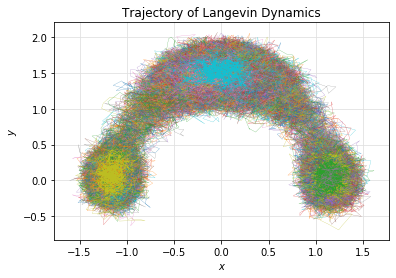

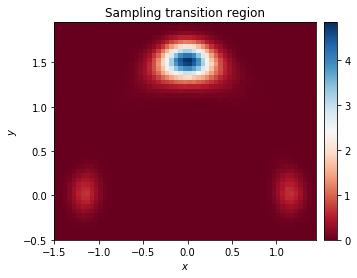

In [6]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = [0.0, 1.5]
    traj = LI(q0, KbT = KbT, isteps = 1000)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
plt.title('Trajectory of Langevin Dynamics')
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.5, 1.5, 0.05).tolist()
    yedges = np.arange(-0.5, 2.0, 0.05).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.title("Sampling transition region")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

The file with all the trajectories is very big, as we can see.

In [7]:
print(trajall.shape)

(999999, 2)


I cut the part of the trajectories that are in the reactant or product state. I look for the point with an high energy (bigger than an arbitrary value -2.41) and that are close to the bottom of the reactant and product state.

In [8]:
# First I cut the trajectories
tmp = 0
for i in range(trajall.shape[0]):
    U = potential(trajall[i])
    if ((trajall[i,0]+1)**2+trajall[i,1]**2 > 1.0 and (trajall[i,0]-1)**2+trajall[i,1]**2 > 1.0) or U >-2.41:
        if tmp==0:
            trajcut = np.copy(trajall[i])
            tmp = 1
        if tmp==1:
            trajcut = np.concatenate((trajcut.reshape(1,2), trajall[i].reshape(1,2)), axis=0)
            tmp = 2
        if tmp==2:
            trajcut = np.concatenate((trajcut, trajall[i].reshape(1,2)), axis=0)

We can see how much information we lose if we do this.

In [9]:
print(trajall.shape)
print(trajcut.shape)

(999999, 2)
(857642, 2)


Let's finally plot the density probability of the cutted trajectory.

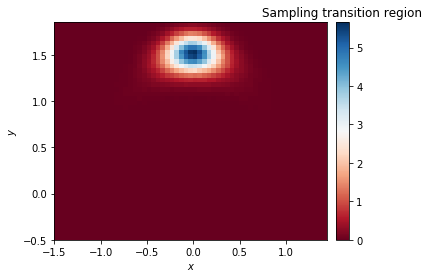

In [10]:
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.5, 1.5, 0.05).tolist()
    yedges = np.arange(-0.5, 1.9, 0.05).tolist()
x = trajcut[:,0]
y = trajcut[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.title("Sampling transition region")
plt.show()

Now I consider only the reactive coordinates. I define a new integrator that stops when a particle reaches the product state.

In [11]:
@njit
def LI_Cut(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    tmp = 0
    while i < isteps - 1 and tmp == 0:
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        i += 1
        if (q[i,0]-1)**2+q[i,1]**2 < 1.0: # Check if we are in product state
            U = potential(q[i,:])
            if U < -2.4:
                tmp = 1.0    #Exit loop
    return q[1:i-1,:]

I run the new integrator to see if it is implemented correctly.

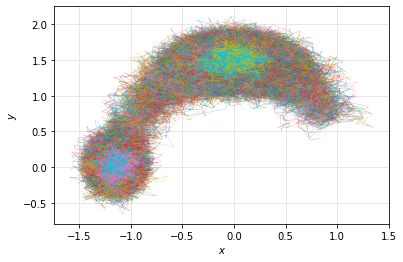

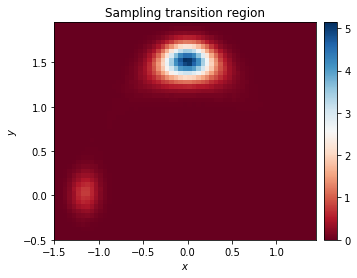

In [12]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = np.array([0.0, 1.5])
    traj = LI_Cut(q0, KbT = KbT, isteps = 1000)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.5, 1.5, 0.05).tolist()
    yedges = np.arange(-0.5, 2.0, 0.05).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.title("Sampling transition region")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

# Langevin in a potential well

If we put our Brownian particle in the reactant state we see that it is very unlikely to exit from the potential well if we are at low temperature.

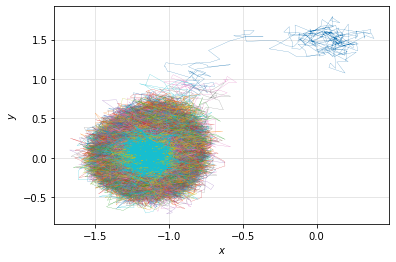

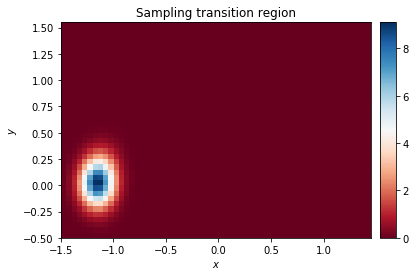

In [13]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj = LI(q0, KbT = KbT, isteps = 1000)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.5, 1.5, 0.05).tolist()
    yedges = np.arange(-0.5, 1.6, 0.05).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.title("Sampling transition region")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Now I consider only the trajectories cutted in the product state

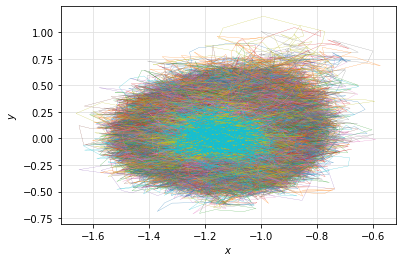

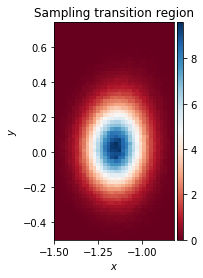

In [14]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj = LI_Cut(q0, KbT = KbT, isteps = 1000)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.5, -0.8, 0.02).tolist()
    yedges = np.arange(-0.5, 0.75, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.title("Sampling transition region")
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Now I do something even more refined: I consider the trajectory only the reactive trajectory, so when it is not in the reactant or the product state

In [15]:
@njit
def LI_R(q0, dt = 0.02, KbT = 0.15, seed=None, isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
        i += 1
        s = state(q[i,:])
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

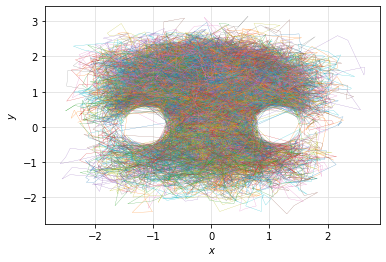

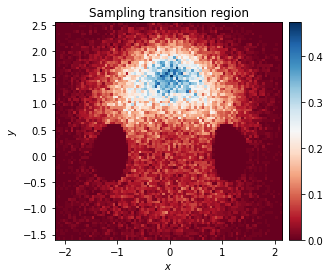

In [16]:
# Fix the temperature
KbT = 1.5
# Figure
plt.figure()
tmp = 0
# Loop over many iterations with different initial conditions
np.random.seed(42)
for i in range(1000):
    # I set a random seed if not stated otherwise
    q0 = np.array([-1.0, 0.0])
    traj = LI_R(q0, KbT = KbT)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.6, 2.6, 0.05).tolist()
else:
    xedges = np.arange(-1.5, 1.5, 0.05).tolist()
    yedges = np.arange(-0.5, 1.6, 0.05).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

## Steered Langevin in a potential wall

As we have seen, it take the particle spends a lot of time in the reactant state. We can force it to moves toward the product state using an extra force towards the product state.

In [17]:
@njit
def LI_S(q0, dt = 0.02, KbT = 0.15, ks = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    for i in range(isteps-1):
        # Evaluate evolution of the system
        z = z_dist(q[i,:])
        f = force(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*(q[i,0] - 1.0)*dt/z
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*q[i,1]*dt/z
    return q[1:,:]

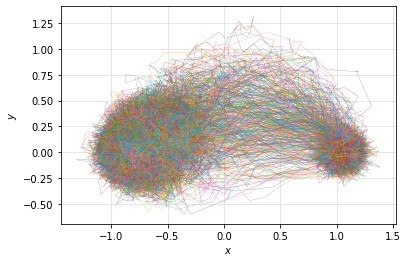

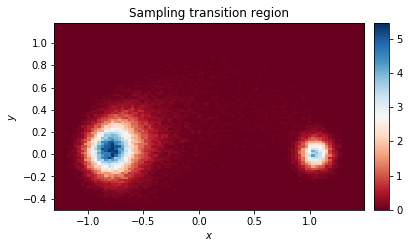

In [18]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj = LI_S(q0, KbT = KbT, ks = 5, isteps = 100)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.3, 1.5, 0.03).tolist()
    yedges = np.arange(-0.5, 1.2, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

As I did before, I cut the trajectory and I look at what is left

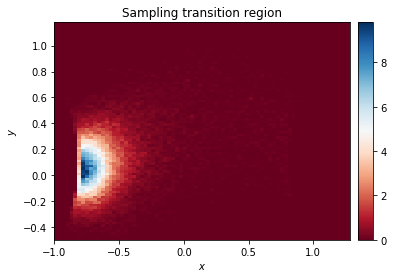

In [19]:
# First I cut the trajectories
tmp = 0
for i in range(trajall.shape[0]):
    U = potential(trajall[i])
    if ((trajall[i,0]+1)**2+trajall[i,1]**2 > 1.0 and (trajall[i,0]-1)**2+trajall[i,1]**2 > 1.0) or U >-2.4:
        if tmp==0:
            trajcut = np.copy(trajall[i])
            tmp = 1
        if tmp==1:
            trajcut = np.concatenate((trajcut.reshape(1,2), trajall[i].reshape(1,2)), axis=0)
            tmp = 2
        if tmp==2:
            trajcut = np.concatenate((trajcut, trajall[i].reshape(1,2)), axis=0)
            
# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1, 1.3, 0.03).tolist()
    yedges = np.arange(-0.5, 1.2, 0.02).tolist()
x = trajcut[:,0]
y = trajcut[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

Now I do as before: I consider only the reactive trajectories.

In [20]:
@njit
def LI_RS(q0, dt = 0.02, KbT = 0.15, ks = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])   
        z = z_dist(q[i,:])
        q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*(q[i,0]-1.0)*dt/z
        q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-ks*q[i,1]*dt/z
        i += 1
        s = state(q[i,:])
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        return out
        
    return q[j+1:i-1,:]

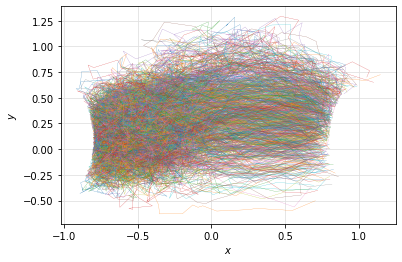

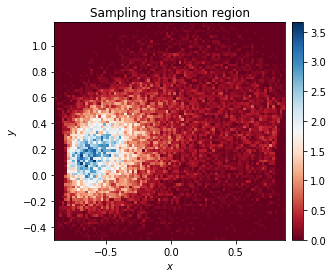

In [21]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj = LI_RS(q0, KbT = KbT, ks = 5)
    if traj[0,0] != 0 and traj[0,1] != 0:
        plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
        if tmp==0:
            trajall = np.copy(traj)
            tmp = 1
        if tmp==1:
            trajall = np.concatenate((trajall, traj), axis=0)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()

# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-0.9, 0.9, 0.02).tolist()
    yedges = np.arange(-0.5, 1.2, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

In [22]:
@njit
def LI_RMD(q0, dt = 0.02, KbT = 0.15, kr = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    z = np.empty(isteps, dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    tmp = 0
    zmin = z_dist(q[0,:])
    for i in range(isteps - 1):
        # Evaluate evolution of the system
        f = force(q[i,:])
        z[i] = z_dist(q[i,:])
        if z[i] < zmin:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmin = z[i]
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*(q[i,0]-1.0)*dt/z[i]
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*q[i,1]*dt/z[i]
    z[-1] = z_dist(q[-1,:])
    return q[1:,:], z

Let's see what we get

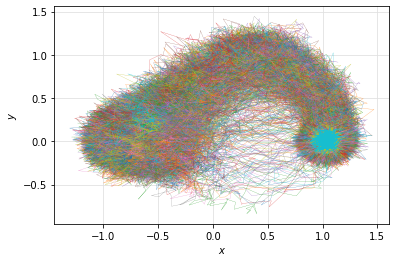

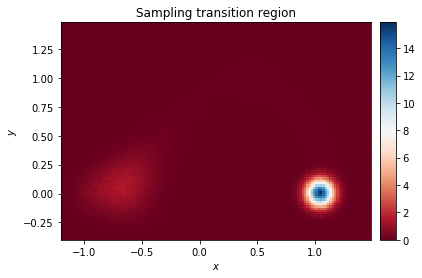

In [23]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj, z = LI_RMD(q0, KbT = KbT, kr = 50, isteps = 500)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    #plt.plot(z)
    del traj, z
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-1.2, 1.5, 0.02).tolist()
    yedges = np.arange(-0.4, 1.5, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

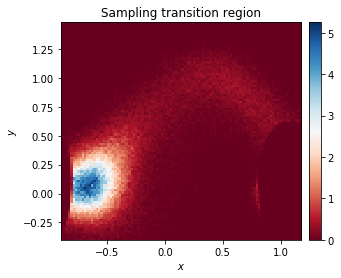

In [24]:
# First I cut the trajectories
tmp = 0
for i in range(trajall.shape[0]):
    U = potential(trajall[i])
    if ((trajall[i,0]+1)**2+trajall[i,1]**2 > 1.0 and (trajall[i,0]-1)**2+trajall[i,1]**2 > 1.0) or U >-2.4:
        if tmp==0:
            trajcut = np.copy(trajall[i])
            tmp = 1
        if tmp==1:
            trajcut = np.concatenate((trajcut.reshape(1,2), trajall[i].reshape(1,2)), axis=0)
            tmp = 2
        if tmp==2:
            trajcut = np.concatenate((trajcut, trajall[i].reshape(1,2)), axis=0)
            
# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-0.9, 1.2, 0.02).tolist()
    yedges = np.arange(-0.4, 1.5, 0.02).tolist()
x = trajcut[:,0]
y = trajcut[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()

I consider only reactive trajectories

In [25]:
@njit
def LI_RRMD(q0, dt = 0.02, KbT = 0.15, kr = 1, seed=None,  isteps = 4000):
    # I set a random seed if not stated otherwise
    if seed is not None:
        np.random.seed(seed)
    # Define preliminary variables
    q = np.empty((isteps, 2), dtype=np.float64)
    z = np.empty(isteps, dtype=np.float64)
    q[0,0] = q0[0]
    q[0,1] = q0[1]
    i = 0
    j = 0
    tmp = 0
    s = state(q[0,:]) #State of the point. If in reactant = -1, if in product = 1, otherwise = 0
    zmin = z_dist(q[0,:])
    #print('State:= ', s)
    while i < isteps - 1 and tmp == 0:
        if s == -1:
            # Restart trajectory
            j = i
        elif s == 1:
            #Exit from loop
            tmp = 1 
        # Evaluate evolution of the system
        f = force(q[i,:])
        z[i] = z_dist(q[i,:])
        if z[i] < zmin:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)
            zmin = z[i]
        else:
            q[i+1,0] = q[i,0]+f[0]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*(q[i,0]-1.0)*dt/z[i]
            q[i+1,1] = q[i,1]+f[1]*dt+np.sqrt(2.0*KbT*dt)*np.random.normal(0,1)-kr*(z[i]-zmin)*q[i,1]*dt/z[i]
        i += 1
        s = state(q[i,:])
        #print('State:= ', s)
        #print('Position:= ',q[i,:])
        #print('Trajectory length:= ', i-j-2)
        
    z[i] = z_dist(q[i,:])
    if tmp == 0:
        print('No reactive trajectory found!')
        out = np.empty((1, 2), dtype=np.float64)
        out[0,0] = 0.0
        out[0,1] = 0.0
        outz = np.empty(1, dtype=np.float64)
        outz[0] = 0.0
        return out, z
        
    return q[j+1:i-1,:], z[j+1:i-1]

Let's see what we get

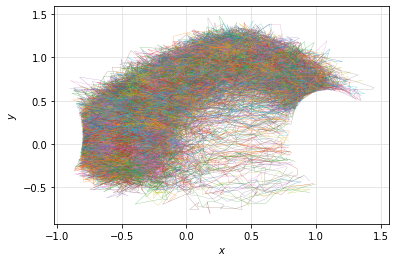

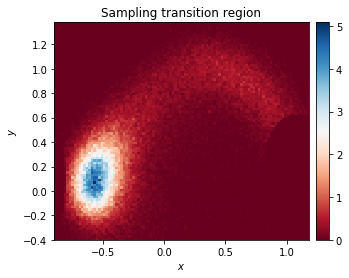

In [26]:
# Fix the temperature
KbT = 0.15
# Figure
plt.figure()
tmp = 0
np.random.seed(42)
for i in range(1000):
    q0 = np.array([-1.0, 0.0])
    traj, z = LI_RRMD(q0, KbT = KbT, kr = 50)
    plt.plot(traj[:,0], traj[:,1], linewidth=0.2)
    #plt.plot(z)
    if tmp==0:
        trajall = np.copy(traj)
        tmp = 1
    if tmp==1:
        trajall = np.concatenate((trajall, traj), axis=0)
    del traj
plt.xlabel('$x$')
plt.ylabel('$y$')
axes = plt.gca()
axes.set_axisbelow(True)
plt.grid(True, which='major', axis='both', color='#e0e0e0')
plt.show()


# Density plot of how much time the system passes in a given point
if KbT == 1.5:
    xedges = np.arange(-2.2, 2.2, 0.05).tolist()
    yedges = np.arange(-1.3, 2.3, 0.05).tolist()
else:
    xedges = np.arange(-0.9, 1.2, 0.02).tolist()
    yedges = np.arange(-0.4, 1.4, 0.02).tolist()
x = trajall[:,0]
y = trajall[:,1]
H, xedges, yedges = np.histogram2d(x, y, bins=(xedges, yedges), density = True)
H = H.T  # Let each row list bins with common y range.
plt.figure()
im = plt.imshow(H, interpolation='nearest', origin='low',extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])
ax = plt.gca()
# colormap, colorbar, labels, ect.
im.set_cmap('RdBu')
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.title("Sampling transition region")
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)
plt.show()